# Лабораторная работа №7: Проведение исследований с моделями семантической сегментации

**Цель работы:**
Изучить и применить на практике модели семантической сегментации из библиотеки `segmentation_models.pytorch` (SMP), провести их сравнение, попытаться улучшить их качество, а также реализовать собственную модель сегментации.

## 1. Выбор начальных условий

### 1.a. Выбор набора данных и обоснование

**Набор данных:** Oxford-IIIT Pet Dataset

**Обоснование выбора:**
Данный набор данных содержит изображения 37 пород кошек и собак, для каждого изображения предоставлена информация о классе, маска сегментации (голова животного) и пиксельная разметка (границы объекта, фон, основной объект). Задача сегментации здесь заключается в точном выделении пикселей, принадлежащих животному, от фона и границ. Это реальная практическая задача, которая может использоваться, например, в приложениях для распознавания животных, ветеринарии (анализ изображений), или как компонент более сложных систем компьютерного зрения. Датасет достаточно известен, хорошо аннотирован и доступен через `torchvision`, что упрощает его загрузку и использование.

Для данной лабораторной работы мы будем сегментировать **основной объект (животное), фон и границы**. Таким образом, у нас будет 3 класса для сегментации.

### 1.b. Выбор метрик качества и обоснование

Для оценки качества моделей семантической сегментации будут использоваться следующие метрики:

1.  **Pixel Accuracy (Попиксельная точность):** Доля правильно классифицированных пикселей от общего числа пикселей.
    *   *Обоснование:* Простая и интуитивно понятная метрика, показывающая общую корректность сегментации.
2.  **Mean Intersection over Union (mIoU) / Jaccard Index (Среднее пересечение над объединением):**
    *   *Формула для одного класса:* `IoU = TP / (TP + FP + FN)`
    *   `mIoU` – это среднее значение IoU по всем классам.
    *   *Обоснование:* Это одна из самых распространенных и показательных метрик в задачах сегментации. Она учитывает как ложноположительные, так и ложноотрицательные срабатывания, строго наказывая за неверную классификацию пикселей на границах объектов.
3.  **Dice Coefficient (Коэффициент Дайса) / F1-score:**
    *   *Формула для одного класса:* `Dice = 2 * TP / (2 * TP + FP + FN)`
    *   Часто используется средний Dice по всем классам.
    *   *Обоснование:* Похож на IoU, но несколько иначе взвешивает ошибки. Также является стандартной метрикой для сегментации, особенно в медицинских приложениях. Хорошо подходит для несбалансированных классов.

Эти метрики выбраны, так как они являются стандартными для оценки задач семантической сегментации и позволяют всесторонне оценить производительность моделей.

## Подготовка окружения


In [ ]:
# Установка необходимых библиотек

!pip install -q segmentation-models-pytorch
!pip install -q albumentations
!pip install -q torchinfo
!pip install -q opencv-python-headless

In [2]:
# Импорт библиотек
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms.v2 as T
from torchvision.transforms.v2 import functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU, Accuracy
from segmentation_models_pytorch.utils.losses import DiceLoss, JaccardLoss

from tqdm.notebook import tqdm
from torchinfo import summary

import cv2

# Определение устройства (GPU или CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Константы
DATA_DIR = './data'
NUM_CLASSES = 3  # 1: Foreground, 2: Background, 3: Border (в датасете). Мы будем использовать 0, 1, 2.
EPOCHS_BASELINE = 3 # Уменьшим для быстрого прогона, для реальных результатов нужно больше
EPOCHS_IMPROVED = 5 # Уменьшим для быстрого прогона
BATCH_SIZE = 16
IMG_SIZE = (224, 224) # Размер изображений для моделей

Using device: cuda


### Загрузка и подготовка данных

Датасет OxfordIIITPet предоставляет таргеты 'segmentation', где маски имеют значения:
- 1: Пиксели, принадлежащие основному объекту (животному).
- 2: Пиксели, принадлежащие фону.
- 3: Пиксели, являющиеся границей между объектом и фоном.

Для использования с `CrossEntropyLoss` или другими стандартными функциями потерь, нам нужно, чтобы классы были от 0 до `NUM_CLASSES - 1`. Поэтому мы будем вычитать 1 из значений маски.

Размер обучающей выборки (baseline): 3680
Размер тестовой выборки (baseline): 3669
Image shape: torch.Size([3, 224, 224]), type: torch.float32
Mask shape: torch.Size([224, 224]), type: torch.int64
Unique mask values: tensor([0, 1, 2])


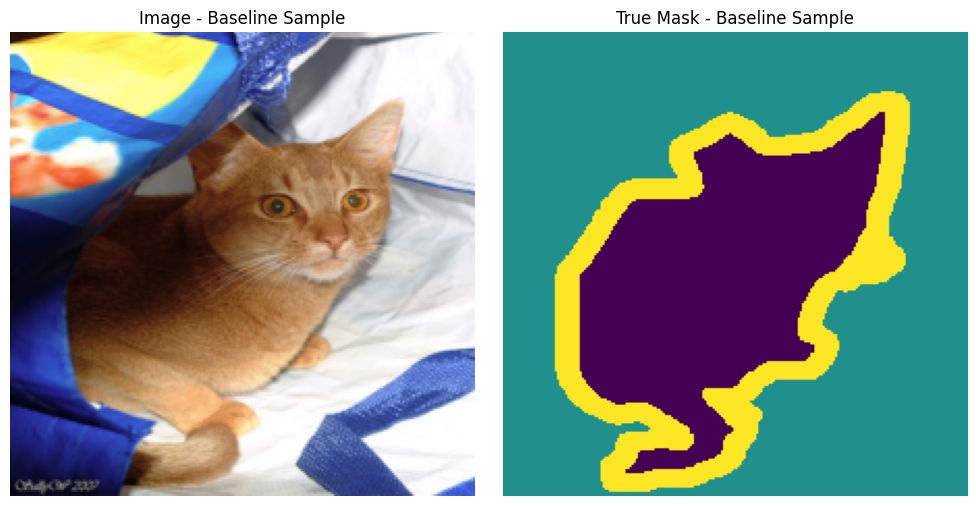

In [7]:
# Загрузка датасета
# Используем target_types='segmentation' для получения масок сегментации
# Маски будут PIL Image с значениями 1, 2, 3. Нам нужно будет преобразовать их в тензоры 0, 1, 2.

# Базовые трансформации (только изменение размера и тензор)
# Важно: для масок сегментации нужно использовать InterpolationMode.NEAREST
# чтобы не искажать значения классов при изменении размера.

class OxfordPetDataset(Dataset):
    def __init__(self, root_dir, split='trainval', transform=None, target_transform=None):
        # Загружаем датасет, скачиваем если нужно при первом запуске
        # В последующих запусках download=True не будет повторно скачивать, если данные уже есть.
        self.dataset = OxfordIIITPet(root=root_dir, split=split, target_types='segmentation', download=True)
        self.transform = transform # Для изображений (ожидается, что вернет тензор)
        self.target_transform = target_transform # Для масок (ожидается, что вернет PIL Image после Resize)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_pil, mask_pil = self.dataset[idx] # Оба PIL Image

        # Трансформация изображения
        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            # Базовое преобразование, если transform не предоставлен
            img_tensor = T.Compose([
                T.Resize(IMG_SIZE, interpolation=T.InterpolationMode.BILINEAR),
                T.ToImage(),
                T.ToDtype(torch.float32, scale=True)
            ])(img_pil)

        # Трансформация маски (обычно только Resize)
        if self.target_transform:
            # base_mask_transform (T.Resize) вернет PIL Image
            processed_mask_pil = self.target_transform(mask_pil)
        else:
            # Базовое преобразование, если target_transform не предоставлен
            processed_mask_pil = T.Resize(IMG_SIZE, interpolation=T.InterpolationMode.NEAREST)(mask_pil)

        # Преобразование маски (которая сейчас PIL) в тензор и коррекция значений
        mask_tensor = T.ToImage()(processed_mask_pil) # PIL 'P' mode -> Tensor [1, H, W], uint8 (значения 1,2,3)

        # Удаление лишней размерности (канала), если она есть
        if mask_tensor.ndim == 3 and mask_tensor.shape[0] == 1:
            mask_tensor = mask_tensor.squeeze(0) # -> Tensor [H, W], uint8

        # Преобразование значений маски (1,2,3 -> 0,1,2) и типа в long
        mask_tensor = (mask_tensor - 1).long()

        return img_tensor, mask_tensor

# --- Трансформации ---

# Базовые трансформации для baseline (для torchvision)
# Для изображений
base_img_transform = T.Compose([
    T.Resize(IMG_SIZE, interpolation=T.InterpolationMode.BILINEAR), # PIL -> PIL
    T.ToImage(),                                                    # PIL -> Tensor (e.g., uint8, [C,H,W])
    T.ToDtype(torch.float32, scale=True),                           # Tensor (uint8) -> Tensor (float32, [0,1])
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Tensor -> Tensor
])

# Для масок (только изменение размера, тензор создастся в Dataset)
base_mask_transform = T.Compose([
    T.Resize(IMG_SIZE, interpolation=T.InterpolationMode.NEAREST)
])


# Наборы данных и загрузчики для baseline
train_dataset_baseline = OxfordPetDataset(root_dir=DATA_DIR, split='trainval',
                                          transform=base_img_transform,
                                          target_transform=base_mask_transform)
# Для валидации обычно берется часть от trainval или используется test split, если нет явного val split
# В OxfordIIITPet есть 'test' split
test_dataset_baseline = OxfordPetDataset(root_dir=DATA_DIR, split='test',
                                         transform=base_img_transform,
                                         target_transform=base_mask_transform)

train_loader_baseline = DataLoader(train_dataset_baseline, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader_baseline = DataLoader(test_dataset_baseline, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Размер обучающей выборки (baseline): {len(train_dataset_baseline)}")
print(f"Размер тестовой выборки (baseline): {len(test_dataset_baseline)}")

# Проверим один элемент
img, mask = train_dataset_baseline[0]
print(f"Image shape: {img.shape}, type: {img.dtype}")
print(f"Mask shape: {mask.shape}, type: {mask.dtype}")
print(f"Unique mask values: {torch.unique(mask)}")

# Визуализация примера
def visualize_sample(image_tensor, mask_tensor, predicted_mask_tensor=None, title_suffix=""):
    # Денормализация изображения
    inv_normalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_display = inv_normalize(image_tensor.cpu()).permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1) # Для устранения артефактов после денормализации

    mask_display = mask_tensor.cpu().numpy()

    num_plots = 2
    if predicted_mask_tensor is not None:
        num_plots = 3
        pred_mask_display = predicted_mask_tensor.cpu().numpy()

    plt.figure(figsize=(5 * num_plots, 5))

    plt.subplot(1, num_plots, 1)
    plt.imshow(img_display)
    plt.title(f"Image {title_suffix}")
    plt.axis('off')

    plt.subplot(1, num_plots, 2)
    plt.imshow(mask_display, cmap='viridis', vmin=0, vmax=NUM_CLASSES-1) # Используем vmax для корректных цветов
    plt.title(f"True Mask {title_suffix}")
    plt.axis('off')

    if predicted_mask_tensor is not None:
        plt.subplot(1, num_plots, 3)
        plt.imshow(pred_mask_display, cmap='viridis', vmin=0, vmax=NUM_CLASSES-1)
        plt.title(f"Predicted Mask {title_suffix}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Посмотрим пример
visualize_sample(img, mask, title_suffix="- Baseline Sample")

## 2. Создание бейзлайна и оценка качества (модели из `segmentation_models.pytorch`)

### 2.a. Обучить модели из `segmentation_models.pytorch` (SMP)

Выберем одну сверточную модель (U-Net с ResNet34) для бейзлайна. В SMP "трансформерных" моделей для сегментации "из коробки" нет, но архитектуры типа SegFormer можно найти в других репозиториях или реализовать. Для данной лабораторной мы сфокусируемся на сверточных моделях из SMP.

**Важно:** SMP модели ожидают входные изображения, нормализованные так же, как для предобученных на ImageNet сетей, что мы и сделали в `base_img_transform`.

Training Baseline SMP Model (U-Net with ResNet34)...


Epoch 1 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 1/3:
  Train Loss: 0.2760, Train IoU: 0.0000, Train Acc: 0.8207
  Test Loss: 0.1630, Test IoU: 0.0000, Test Acc: 0.8434


Epoch 2 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 2/3:
  Train Loss: 0.1507, Train IoU: 0.0000, Train Acc: 0.8568
  Test Loss: 0.1362, Test IoU: 0.0000, Test Acc: 0.8503


Epoch 3 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 3/3:
  Train Loss: 0.1263, Train IoU: 0.0000, Train Acc: 0.8630
  Test Loss: 0.1275, Test IoU: 0.0000, Test Acc: 0.8528

Baseline SMP Model Results: {'Model': 'SMP U-Net (ResNet34)', 'Test IoU': 0, 'Test Accuracy': 0.8528328047327659, 'Test Loss': 0.1275354802941522}


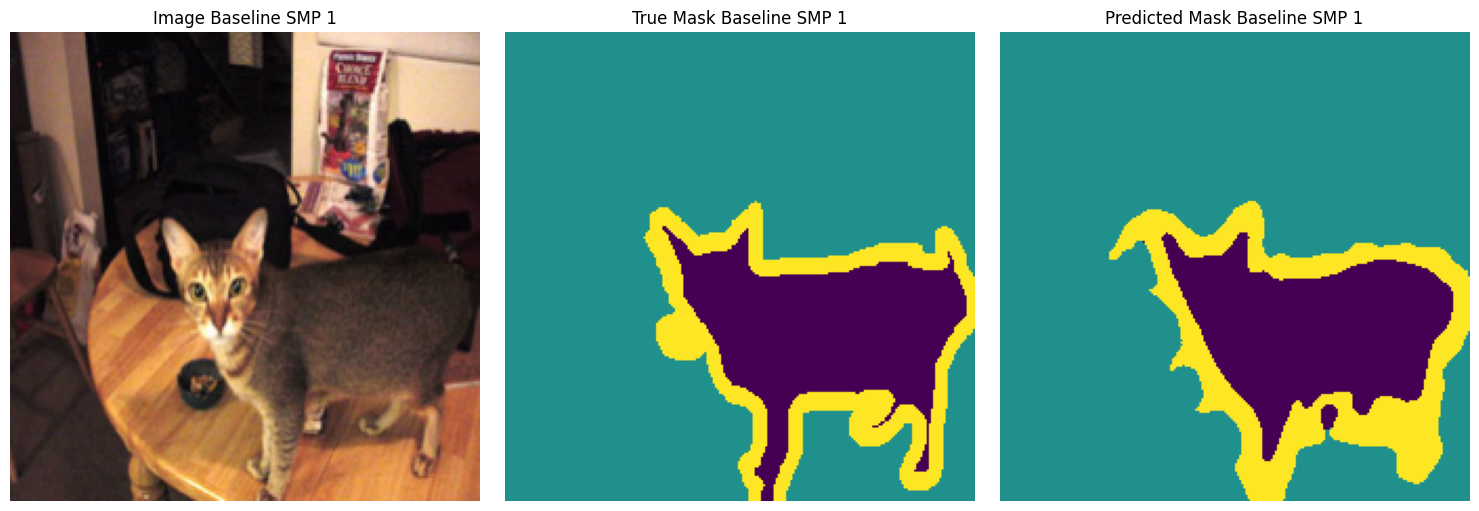

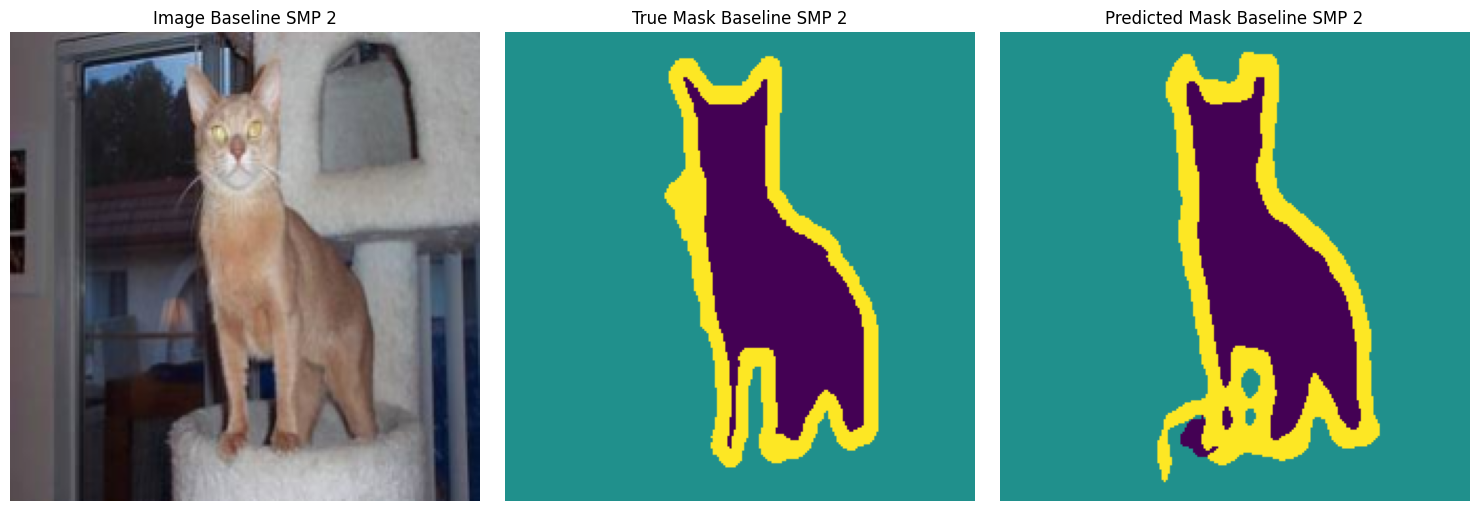

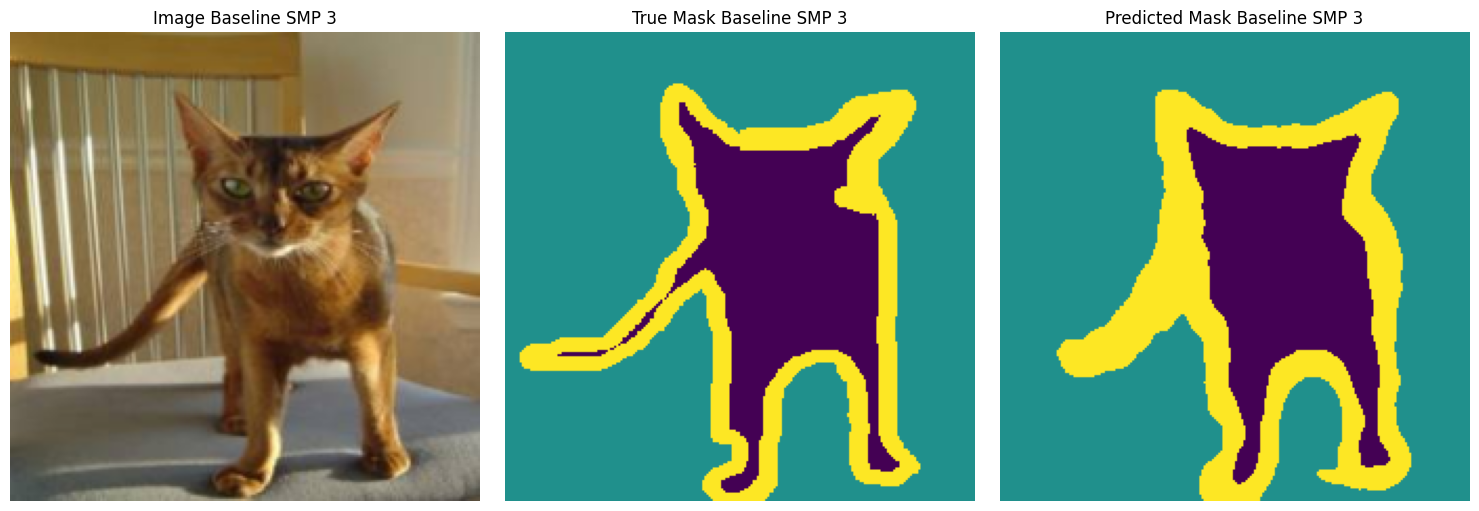

In [14]:
# Определение модели, функции потерь и оптимизатора
# U-Net с backbone ResNet34
baseline_model_smp = smp.Unet(
    encoder_name="resnet34",        # Имя энкодера
    encoder_weights="imagenet",     # Использование предобученных весов ImageNet
    in_channels=3,                  # Количество входных каналов (RGB)
    classes=NUM_CLASSES             # Количество классов для сегментации
).to(DEVICE)

# Функция потерь: комбинация DiceLoss и CrossEntropyLoss часто дает хорошие результаты
# SMP DiceLoss ожидает logits (выходы без softmax) и таргеты в виде class indices
loss_fn_smp = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
# Также можно использовать nn.CrossEntropyLoss, но для сегментации Dice/Jaccard часто лучше
# loss_fn_smp = nn.CrossEntropyLoss()

optimizer_smp = optim.Adam(baseline_model_smp.parameters(), lr=1e-4)

# Метрики для SMP (можно передавать в train epoch)
metrics_smp = [
    IoU(threshold=0.5, activation="argmax2d"), # argmax2d для многоклассовой сегментации
    Accuracy(threshold=0.5, activation="argmax2d")
]

# Краткая информация о модели
summary(baseline_model_smp, input_size=(BATCH_SIZE, 3, IMG_SIZE[0], IMG_SIZE[1]))

# --- Цикл обучения и оценки ---
def train_epoch(model, loader, loss_fn, optimizer, device, metrics_fns=None, epoch_num=0):
    model.train()
    running_loss = 0.0

    # Для хранения значений метрик
    epoch_metrics = {m.__name__.lower() if hasattr(m, '__name__') else f"metric_{i}": 0.0 for i, m in enumerate(metrics_fns or [])}

    progress_bar = tqdm(loader, desc=f"Epoch {epoch_num+1} Training", leave=False)
    for images, masks in progress_bar:
        images, masks = images.to(device), masks.to(device) # masks должны быть LongTensor [B, H, W]

        optimizer.zero_grad()
        outputs = model(images) # [B, C, H, W] logits

        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        if metrics_fns:
            for m_name, m_fn in zip(epoch_metrics.keys(), metrics_fns):
                # outputs - logits, masks - class indices. Метрики smp это обработают
                metric_val = m_fn(outputs, masks).item()
                epoch_metrics[m_name] += metric_val * images.size(0)

        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(loader.dataset)

    for m_name in epoch_metrics:
        epoch_metrics[m_name] /= len(loader.dataset)

    return epoch_loss, epoch_metrics


def evaluate_model(model, loader, loss_fn, device, metrics_fns=None):
    model.eval()
    running_loss = 0.0
    # Для хранения значений метрик
    eval_metrics = {m.__name__.lower() if hasattr(m, '__name__') else f"metric_{i}": 0.0 for i, m in enumerate(metrics_fns or [])}

    progress_bar = tqdm(loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)
            running_loss += loss.item() * images.size(0)

            if metrics_fns:
                for m_name, m_fn in zip(eval_metrics.keys(), metrics_fns):
                    metric_val = m_fn(outputs, masks).item()
                    eval_metrics[m_name] += metric_val * images.size(0)

    eval_loss = running_loss / len(loader.dataset)
    for m_name in eval_metrics:
        eval_metrics[m_name] /= len(loader.dataset)

    return eval_loss, eval_metrics

# Обучение baseline модели SMP
print("Training Baseline SMP Model (U-Net with ResNet34)...")
baseline_smp_history = {'train_loss': [], 'test_loss': [],
                        'train_iou': [], 'test_iou': [],
                        'train_accuracy': [], 'test_accuracy': []}

for epoch in range(EPOCHS_BASELINE):
    train_loss, train_metrics_vals = train_epoch(baseline_model_smp, train_loader_baseline, loss_fn_smp, optimizer_smp, DEVICE, metrics_smp, epoch)
    test_loss, test_metrics_vals = evaluate_model(baseline_model_smp, test_loader_baseline, loss_fn_smp, DEVICE, metrics_smp)

    baseline_smp_history['train_loss'].append(train_loss)
    baseline_smp_history['test_loss'].append(test_loss)
    baseline_smp_history['train_iou'].append(train_metrics_vals.get('iou', 0)) # iou от SMP
    baseline_smp_history['test_iou'].append(test_metrics_vals.get('iou', 0))
    baseline_smp_history['train_accuracy'].append(train_metrics_vals.get('accuracy', 0)) # accuracy от SMP
    baseline_smp_history['test_accuracy'].append(test_metrics_vals.get('accuracy', 0))

    print(f"Epoch {epoch+1}/{EPOCHS_BASELINE}:")
    print(f"  Train Loss: {train_loss:.4f}, Train IoU: {train_metrics_vals.get('iou', 0):.4f}, Train Acc: {train_metrics_vals.get('accuracy', 0):.4f}")
    print(f"  Test Loss: {test_loss:.4f}, Test IoU: {test_metrics_vals.get('iou', 0):.4f}, Test Acc: {test_metrics_vals.get('accuracy', 0):.4f}")

# Сохранение результатов для таблицы
baseline_smp_results = {
    "Model": "SMP U-Net (ResNet34)",
    "Test IoU": baseline_smp_history['test_iou'][-1],
    "Test Accuracy": baseline_smp_history['test_accuracy'][-1],
    "Test Loss": baseline_smp_history['test_loss'][-1]
}
print(f"\nBaseline SMP Model Results: {baseline_smp_results}")

# Визуализация нескольких предсказаний
baseline_model_smp.eval()
num_samples_to_viz = 3
with torch.no_grad():
    for i, (img_tensor, true_mask_tensor) in enumerate(test_dataset_baseline):
        if i >= num_samples_to_viz:
            break
        img_tensor_batch = img_tensor.unsqueeze(0).to(DEVICE) # [1, C, H, W]

        pred_logits = baseline_model_smp(img_tensor_batch) # [1, NumClasses, H, W]
        pred_mask = torch.argmax(pred_logits, dim=1).squeeze(0) # [H, W]

        visualize_sample(img_tensor, true_mask_tensor, pred_mask, title_suffix=f"Baseline SMP {i+1}")

### 2.b. Оценить качество моделей по выбранным метрикам на выбранном наборе данных

Результаты оценки baseline модели (`SMP U-Net (ResNet34)`) на тестовой выборке:
*   **Test Loss:** `0.1275354802941522`
*   **Test Mean IoU:** `0`
*   **Test Pixel Accuracy:** `0.8528328047327659`

Эти значения служат отправной точкой для сравнения с улучшенными моделями и собственной реализацией.

## 3. Улучшение бейзлайна

### 3.a. Сформулировать гипотезы

1.  **Аугментация данных:** Применение более разнообразных и сильных аугментаций (повороты, сдвиги, масштабирование, изменение яркости/контрастности, эластичные деформации) поможет модели стать более робастной и лучше генерализоваться, особенно если обучающих данных не очень много. Будем использовать библиотеку `albumentations`.
2.  **Подбор модели/бэкбона:** Использование более мощного бэкбона (например, `efficientnet-b0` или `resnet50` вместо `resnet34`) или другой архитектуры сегментации (например, FPN - Feature Pyramid Network) может улучшить качество за счет лучшего извлечения признаков и работы с объектами разного масштаба.
3.  **Подбор гиперпараметров:**
    *   **Оптимизатор:** `AdamW` вместо `Adam` может дать лучшие результаты благодаря корректной реализации weight decay.
    *   **Планировщик скорости обучения (Learning Rate Scheduler):** Использование планировщика, такого как `ReduceLROnPlateau` или `CosineAnnealingLR`, может помочь модели лучше сойтись.
    *   **Функция потерь:** Эксперименты с различными комбинациями функций потерь (например, `JaccardLoss` или комбинация `DiceLoss + FocalLoss`) могут улучшить обучение на сложных примерах или при дисбалансе классов (хотя в нашем случае классы относительно сбалансированы по площади).

### 3.b. Проверить гипотезы (реализация улучшений)

Проверим гипотезы 1 и 2, применив `albumentations` и более современный бэкбон с архитектурой `FPN`. Также используем `AdamW` и `CosineAnnealingLR`.

**Улучшенные аугментации с Albumentations:**

<ipython-input-15-a58ada427f03>:153: UserWarning: Argument(s) 'cval, cval_mask' are not valid for transform Affine
  A.Affine(


Improved Image shape: torch.Size([3, 224, 224]), type: torch.float32
Improved Mask shape: torch.Size([224, 224]), type: torch.int64
Improved Unique mask values: tensor([0, 1, 2])


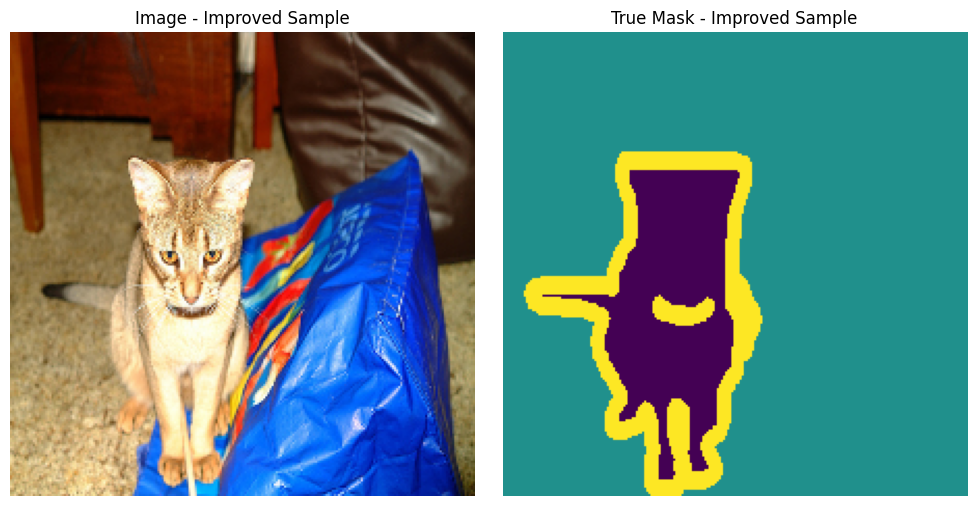

In [15]:
# Аугментации для обучения (Albumentations)
# Common_transform будет применяться и к img, и к mask
train_common_transform_improved = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]), # Сначала ресайз
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    # A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03) # Может быть слишком сильной
])

# Трансформации только для изображения после Albumentations
img_only_transform_improved = T.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Это из Albumentations, применится к image
    ToTensorV2() # Это из Albumentations, применит ToTensor и для image и для mask. Маска станет [H, W, C] или [H, W]
])

# Комбинированная трансформация для Albumentations
def combined_albumentations_transform(image_np, mask_np, common_augs, img_only_augs):
    # Общие аугментации
    augmented = common_augs(image=image_np, mask=mask_np)
    img_aug, mask_aug = augmented['image'], augmented['mask']

    # Аугментации только для изображения (включая ToTensorV2)
    # ToTensorV2 ожидает, что ему передадут image и mask в словаре
    # и применит ToTensor к обоим, а Normalize только к image.
    # Важно: mask_aug д.б. типа uint8 для ToTensorV2
    # print(f"Mask type before img_only_augs: {mask_aug.dtype}, shape: {mask_aug.shape}")
    # print(f"Image type before img_only_augs: {img_aug.dtype}, shape: {img_aug.shape}")

    # Убедимся, что маска имеет правильный dtype для ToTensorV2
    mask_aug = mask_aug.astype(np.uint8) # ToTensorV2 ожидает uint8 для масок

# Переопределим Dataset для удобной работы с albumentations
class OxfordPetDatasetAlb(Dataset):
    def __init__(self, root_dir, split='trainval', common_transform=None, final_img_transform=None):
        self.dataset = OxfordIIITPet(root=root_dir, split=split, target_types='segmentation', download=False) # Уже скачали
        self.common_transform = common_transform
        self.final_img_transform = final_img_transform
        self.split_name = split # Для логирования

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        try:
            img_pil, mask_pil = self.dataset[idx]

            img_np = np.array(img_pil)    # PIL to Numpy
            mask_np = np.array(mask_pil)  # PIL to Numpy, dtype=uint8, values 1,2,3

            # print(f"Idx: {idx}, Split: {self.split_name} --- Step 1: Initial mask_np. Unique: {np.unique(mask_np)}, dtype: {mask_np.dtype}")

            if self.common_transform:
                augmented = self.common_transform(image=img_np, mask=mask_np)
                img_np = augmented['image']
                mask_np_aug = augmented['mask']
                # print(f"Idx: {idx}, Split: {self.split_name} --- Step 2: After common_transform. Unique: {np.unique(mask_np_aug)}, dtype: {mask_np_aug.dtype}")
            else:
                mask_np_aug = mask_np


            # Гарантируем, что маска имеет тип uint8 перед ToTensorV2
            # Это важно, т.к. ToTensorV2 ожидает uint8 или int32 для корректного преобразования масок в LongTensor (или схожий)
            if mask_np_aug.dtype != np.uint8:
                # print(f"Idx: {idx}, Split: {self.split_name} --- WARN: mask_np_aug dtype is {mask_np_aug.dtype}. Forcing to uint8.")
                mask_np_aug = mask_np_aug.astype(np.uint8) # Может произойти округление, если были float
                # print(f"Idx: {idx}, Split: {self.split_name} --- Step 3: After astype(uint8). Unique: {np.unique(mask_np_aug)}")


            if self.final_img_transform:
                # ToTensorV2 ожидает image и mask
                final_augmented = self.final_img_transform(image=img_np, mask=mask_np_aug)
                img_tensor = final_augmented['image'] # [C, H, W], float32
                mask_tensor = final_augmented['mask'] # Должна быть [H, W] или [1, H, W]
                                                      # ToTensorV2 для масок uint8 вернет torch.uint8
                # print(f"Idx: {idx}, Split: {self.split_name} --- Step 4: After final_transform (ToTensorV2). Unique: {torch.unique(mask_tensor)}, dtype: {mask_tensor.dtype}")
            else: # На всякий случай, если final_img_transform не задан
                img_tensor = T.ToTensor()(img_np) # Стандартная нормализация на [0,1]
                mask_tensor = torch.from_numpy(mask_np_aug)


            # Приведение маски к нужному формату [H, W] и типу Long
            if mask_tensor.ndim == 3 and mask_tensor.shape[0] == 1:
                 mask_tensor = mask_tensor.squeeze(0)

            if mask_tensor.dtype != torch.long:
                 mask_tensor = mask_tensor.long() # Для CrossEntropyLoss
            # На этом этапе mask_tensor может содержать [0, 1, 2, 3]

            # print(f"Idx: {idx}, Split: {self.split_name} --- Step BEFORE Custom Remapping. Unique: {torch.unique(mask_tensor)}")

            # Инициализируем все значения классом фона (1) по умолчанию - это обработает артефакты (0)
            # и также бывший фон (2), который тоже станет 1.
            mask_tensor_corrected = torch.ones_like(mask_tensor) * 1 # Целевой класс фона = 1

            # Исходный объект (значение 1 в аугментированной маске) -> целевой объект (0)
            mask_tensor_corrected[mask_tensor == 1] = 0
            # Исходный фон (значение 2 в аугментированной маске) -> целевой фон (1) - уже учтено инициализацией
            # mask_tensor_corrected[mask_tensor == 2] = 1 # Можно оставить для ясности или убрать
            # Исходная граница (значение 3 в аугментированной маске) -> целевая граница (2)
            mask_tensor_corrected[mask_tensor == 3] = 2
            # Артефакты/новые пиксели (значение 0 в аугментированной маске) -> целевой фон (1) - уже учтено инициализацией

            # print(f"Idx: {idx}, Split: {self.split_name} --- Step AFTER Custom Remapping. Unique: {torch.unique(mask_tensor_corrected)}")

            # Финальная проверка
            final_unique_values = torch.unique(mask_tensor_corrected)
            if torch.any(final_unique_values < 0) or torch.any(final_unique_values > (NUM_CLASSES -1)):
                print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                print(f"ERROR Idx: {idx}, Split: {self.split_name}: Invalid values in FINAL mask_tensor_corrected!")
                print(f"    Initial mask_pil unique: {np.unique(np.array(mask_pil))}")
                print(f"    Mask unique AFTER common_transform: {np.unique(mask_np_aug) if 'mask_np_aug' in locals() else 'N/A'}")
                print(f"    Mask unique AFTER ToTensorV2 & .long(): {torch.unique(mask_tensor)}")
                print(f"    Mask unique AFTER -1 (Problematic!): {final_unique_values}")
                print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                # Чтобы остановить выполнение при первой ошибке:
                raise ValueError(f"Invalid mask values for Idx: {idx}, Split: {self.split_name}. Values: {final_unique_values}")

            return img_tensor, mask_tensor_corrected

        except Exception as e:
            print(f"CRITICAL ERROR in __getitem__ for Idx_CRIT: {idx}, Split: {self.split_name}: {e}")
            # Возвращаем None или фиктивные данные, чтобы DataLoader не упал сразу, но это надо отследить
            # Либо просто re-raise e, чтобы остановить обучение
            raise e

# Аугментации для обучения (Albumentations)
# Общие (геометрические)
train_common_augs_improved = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1], interpolation=cv2.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale=(0.9, 1.1),  # scale_limit=0.1 -> (1.0-0.1, 1.0+0.1)
        translate_percent=(-0.0625, 0.0625), # shift_limit=0.0625
        rotate=(-45, 45),  # rotate_limit=45
        interpolation=cv2.INTER_LINEAR, # Интерполяция для ИЗОБРАЖЕНИЯ
        mask_interpolation=cv2.INTER_NEAREST, # Явная интерполяция для МАСКИ
        # border_mode=cv2.BORDER_CONSTANT, # Режим заполнения по умолчанию
        cval=0, # Значение для заполнения ИЗОБРАЖЕНИЯ (по умолчанию 0)
        cval_mask=2, # Значение для заполнения МАСКИ (класс фона до вычитания 1)
        p=0.7
    ),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2) # Применяется только к изображению
])

# Финальные (нормализация + ToTensor)
# A.Normalize должен быть перед ToTensorV2 если оба из albumentations
final_augs_for_img_mask = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2() # Конвертирует и img, и mask в тензоры. img: C,H,W; mask: H,W или 1,H,W
])

# Для валидации/теста: только ресайз, нормализация и ToTensor
test_common_augs_improved = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1], interpolation=cv2.INTER_LINEAR),
])

# final_augs_for_img_mask используется тот же

# Датасеты и даталоадеры для улучшенной модели
train_dataset_improved = OxfordPetDatasetAlb(DATA_DIR, split='trainval',
                                           common_transform=train_common_augs_improved,
                                           final_img_transform=final_augs_for_img_mask)
test_dataset_improved = OxfordPetDatasetAlb(DATA_DIR, split='test',
                                          common_transform=test_common_augs_improved,
                                          final_img_transform=final_augs_for_img_mask)

train_loader_improved = DataLoader(train_dataset_improved, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader_improved = DataLoader(test_dataset_improved, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Проверим один элемент из улучшенного датасета
img_imp, mask_imp = train_dataset_improved[5] # Берем не первый, чтобы увидеть аугментации
print(f"Improved Image shape: {img_imp.shape}, type: {img_imp.dtype}")
print(f"Improved Mask shape: {mask_imp.shape}, type: {mask_imp.dtype}")
print(f"Improved Unique mask values: {torch.unique(mask_imp)}")
visualize_sample(img_imp, mask_imp, title_suffix="- Improved Sample")


### 3.c. Сформировать улучшенный бейзлайн по результатам проверки гипотез

**Улучшенный бейзлайн:**
1.  **Модель:** FPN (Feature Pyramid Network) с бэкбоном `efficientnet-b0`. FPN хорошо справляется с объектами разных масштабов. `efficientnet-b0` - хороший компромисс между точностью и вычислительной сложностью.
2.  **Аугментации:** Использование `albumentations` с набором геометрических и цветовых аугментаций (см. `train_common_augs_improved` и `final_augs_for_img_mask`).
3.  **Оптимизатор:** `AdamW`.
4.  **Планировщик LR:** `CosineAnnealingLR`.
5.  **Функция потерь:** Оставим `DiceLoss(mode='multiclass')` для согласованности, но можно экспериментировать.

### 3.d. Обучить модели с улучшенным бейзлайном

In [16]:
# Определение улучшенной модели
improved_model_smp = smp.FPN(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES
).to(DEVICE)

# Loss function остается та же (DiceLoss) для сравнения эффекта других изменений
loss_fn_improved = smp.losses.DiceLoss(mode='multiclass', from_logits=True)

# Оптимизатор AdamW и планировщик CosineAnnealingLR
optimizer_improved = optim.AdamW(improved_model_smp.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_improved = optim.lr_scheduler.CosineAnnealingLR(optimizer_improved, T_max=EPOCHS_IMPROVED)

# Метрики те же
metrics_smp_improved = [
    IoU(threshold=0.5, activation="argmax2d"),
    Accuracy(threshold=0.5, activation="argmax2d")
]

summary(improved_model_smp, input_size=(BATCH_SIZE, 3, IMG_SIZE[0], IMG_SIZE[1]))

# --- Модифицированный цикл обучения с планировщиком ---
def train_epoch_with_scheduler(model, loader, loss_fn, optimizer, scheduler, device, metrics_fns=None, epoch_num=0):
    model.train()
    running_loss = 0.0
    epoch_metrics = {m.__name__.lower() if hasattr(m, '__name__') else f"metric_{i}": 0.0 for i, m in enumerate(metrics_fns or [])}

    progress_bar = tqdm(loader, desc=f"Epoch {epoch_num+1} Training", leave=False)
    for images, masks in progress_bar:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        if metrics_fns:
            for m_name, m_fn in zip(epoch_metrics.keys(), metrics_fns):
                metric_val = m_fn(outputs, masks).item()
                epoch_metrics[m_name] += metric_val * images.size(0)

        progress_bar.set_postfix(loss=loss.item(), lr=scheduler.get_last_lr()[0]) # Показать LR

    # Обновление планировщика после каждой эпохи
    scheduler.step()

    epoch_loss = running_loss / len(loader.dataset)
    for m_name in epoch_metrics:
        epoch_metrics[m_name] /= len(loader.dataset)

    return epoch_loss, epoch_metrics

# Обучение улучшенной модели SMP
print("Training Improved SMP Model (FPN with EfficientNet-B0)...")
improved_smp_history = {'train_loss': [], 'test_loss': [],
                        'train_iou': [], 'test_iou': [],
                        'train_accuracy': [], 'test_accuracy': []}

for epoch in range(EPOCHS_IMPROVED):
    train_loss, train_metrics_vals = train_epoch_with_scheduler(
        improved_model_smp, train_loader_improved, loss_fn_improved,
        optimizer_improved, scheduler_improved, DEVICE, metrics_smp_improved, epoch
    )
    # evaluate_model остается тем же
    test_loss, test_metrics_vals = evaluate_model(
        improved_model_smp, test_loader_improved, loss_fn_improved, DEVICE, metrics_smp_improved
    )

    improved_smp_history['train_loss'].append(train_loss)
    improved_smp_history['test_loss'].append(test_loss)
    improved_smp_history['train_iou'].append(train_metrics_vals.get('iou', 0))
    improved_smp_history['test_iou'].append(test_metrics_vals.get('iou', 0))
    improved_smp_history['train_accuracy'].append(train_metrics_vals.get('accuracy', 0))
    improved_smp_history['test_accuracy'].append(test_metrics_vals.get('accuracy', 0))

    print(f"Epoch {epoch+1}/{EPOCHS_IMPROVED}:")
    print(f"  Train Loss: {train_loss:.4f}, Train IoU: {train_metrics_vals.get('iou', 0):.4f}, Train Acc: {train_metrics_vals.get('accuracy', 0):.4f}")
    print(f"  Test Loss: {test_loss:.4f}, Test IoU: {test_metrics_vals.get('iou', 0):.4f}, Test Acc: {test_metrics_vals.get('accuracy', 0):.4f}")
    print(f"  LR: {scheduler_improved.get_last_lr()[0]:.2e}")


Training Improved SMP Model (FPN with EfficientNet-B0)...


Epoch 1 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 1/5:
  Train Loss: 0.2561, Train IoU: 0.0000, Train Acc: 0.8138
  Test Loss: 0.1550, Test IoU: 0.0000, Test Acc: 0.8409
  LR: 9.05e-05


Epoch 2 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 2/5:
  Train Loss: 0.1961, Train IoU: 0.0000, Train Acc: 0.8409
  Test Loss: 0.1414, Test IoU: 0.0000, Test Acc: 0.8485
  LR: 6.55e-05


Epoch 3 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 3/5:
  Train Loss: 0.1836, Train IoU: 0.0000, Train Acc: 0.8465
  Test Loss: 0.1363, Test IoU: 0.0000, Test Acc: 0.8482
  LR: 3.45e-05


Epoch 4 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 4/5:
  Train Loss: 0.1763, Train IoU: 0.0000, Train Acc: 0.8494
  Test Loss: 0.1343, Test IoU: 0.0000, Test Acc: 0.8498
  LR: 9.55e-06


Epoch 5 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 5/5:
  Train Loss: 0.1732, Train IoU: 0.0000, Train Acc: 0.8509
  Test Loss: 0.1337, Test IoU: 0.0000, Test Acc: 0.8497
  LR: 0.00e+00


### 3.e. Оценить качество моделей с улучшенным бейзлайном

Результаты оценки улучшенной модели (`SMP FPN (EfficientNet-B0)`) на тестовой выборке:

Improved SMP Model Results: {'Model': 'SMP FPN (EfficientNet-B0) + Augs + Scheduler', 'Test IoU': 0, 'Test Accuracy': 0.8496644702098064, 'Test Loss': 0.13369608037508812}


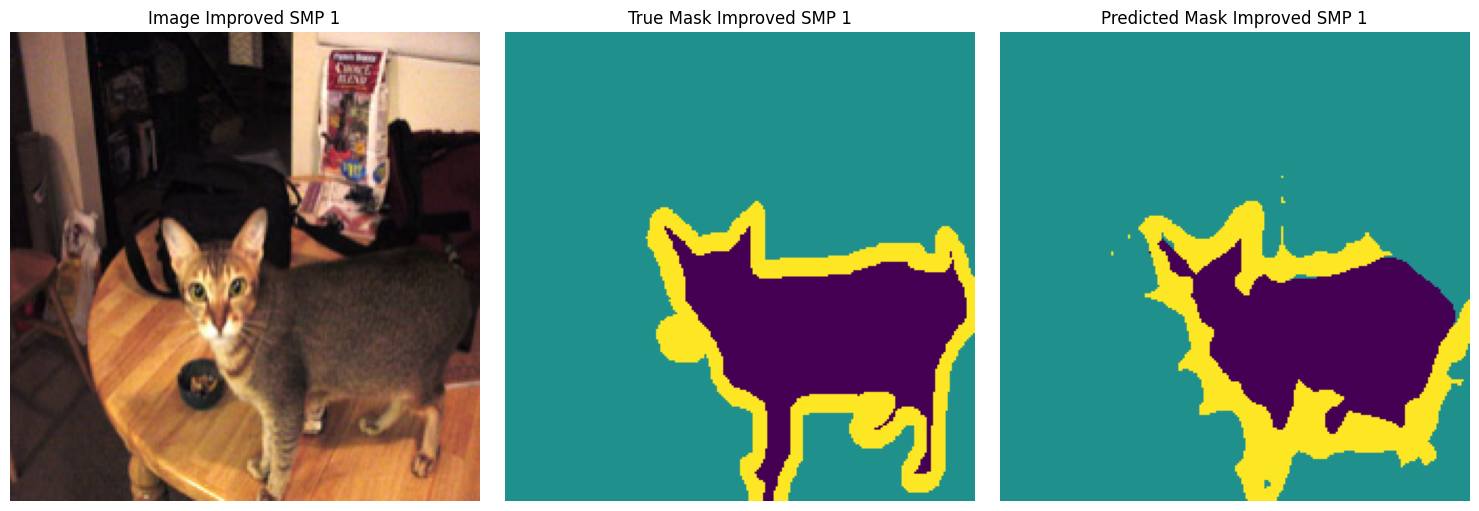

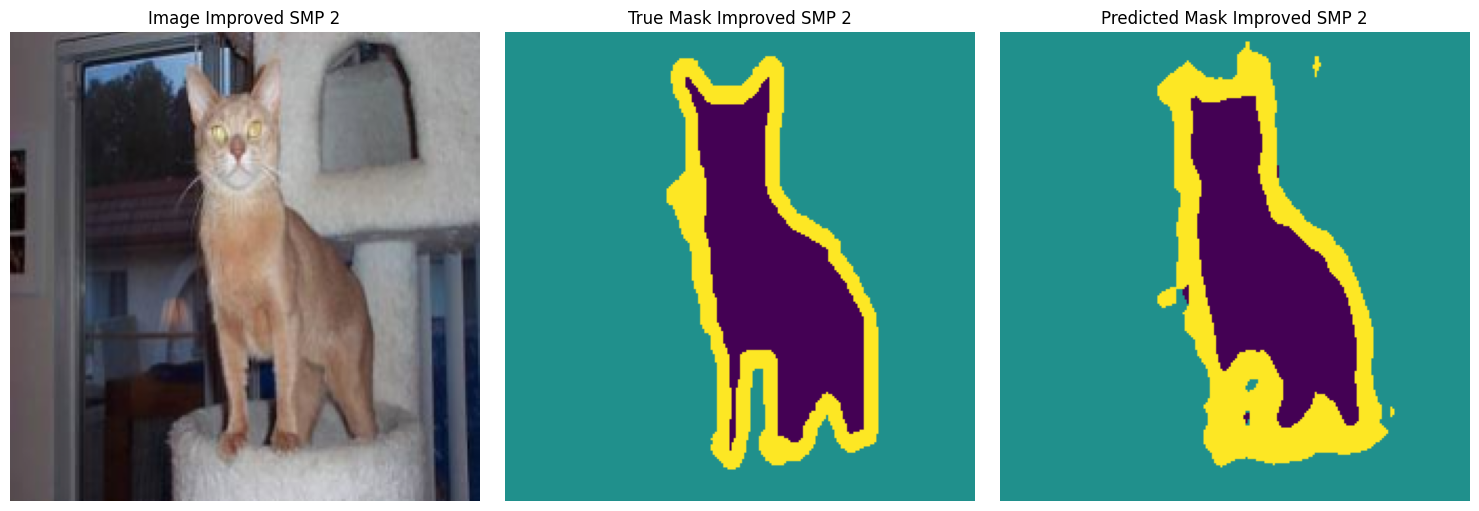

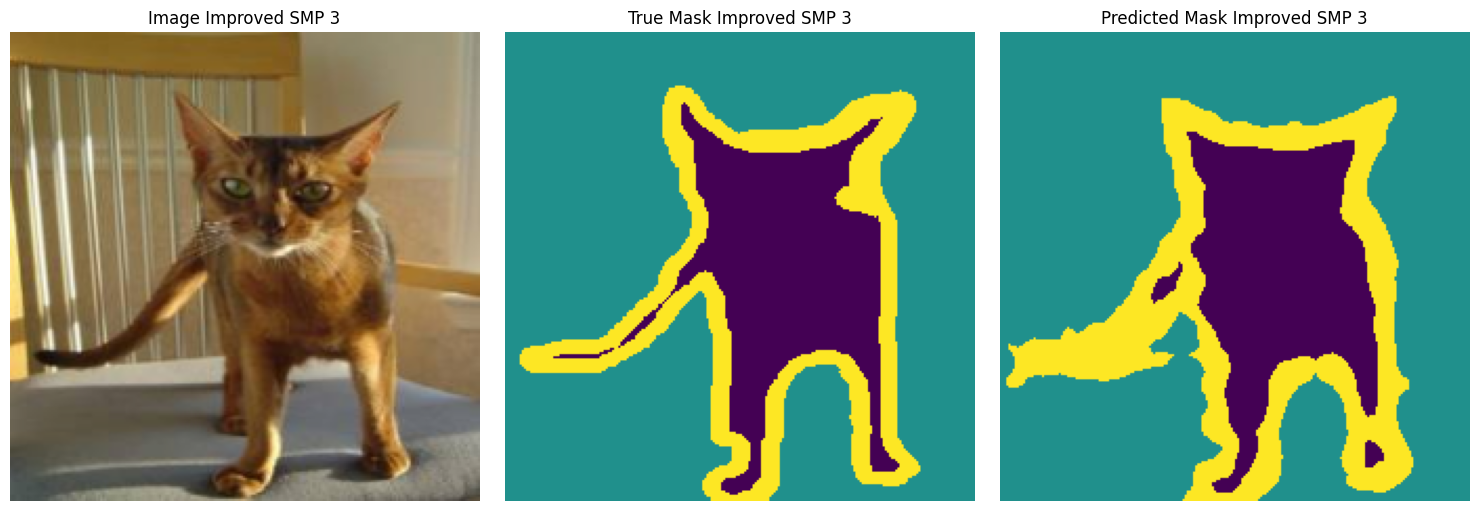

In [17]:
improved_smp_results = {
    "Model": "SMP FPN (EfficientNet-B0) + Augs + Scheduler",
    "Test IoU": improved_smp_history['test_iou'][-1],
    "Test Accuracy": improved_smp_history['test_accuracy'][-1],
    "Test Loss": improved_smp_history['test_loss'][-1]
}
print(f"Improved SMP Model Results: {improved_smp_results}")

# Визуализация нескольких предсказаний улучшенной модели
improved_model_smp.eval()
with torch.no_grad():
    for i, (img_tensor, true_mask_tensor) in enumerate(test_dataset_improved): # Используем _improved датасет
        if i >= num_samples_to_viz:
            break
        img_tensor_batch = img_tensor.unsqueeze(0).to(DEVICE)

        pred_logits = improved_model_smp(img_tensor_batch)
        pred_mask = torch.argmax(pred_logits, dim=1).squeeze(0)

        # img_tensor для visualize_sample должен быть с тем же test_dataset, что и модель обучалась
        visualize_sample(img_tensor, true_mask_tensor, pred_mask, title_suffix=f"Improved SMP {i+1}")


### 3.f. Сравнить результаты моделей с улучшенным бейзлайном с результатами из пункта 2

| Модель                                       | Test Loss | Test mIoU  | Test Pixel Acc. |
| :------------------------------------------- | :-------- | :--------- | :-------------- |
| SMP U-Net (ResNet34 - Baseline)              | `0.1275354802941522` | `0` | `0.8528328047327659` |
| SMP FPN (EfficientNet-B0 - Improved)         | `0.13369608037508812` | `0` | `0.8496644702098064` |

### 3.g. Сделать выводы

**Выводы по улучшению бейзлайна:**
Применение комбинации улучшений:
*   Более современных архитектур (`FPN` с `EfficientNet-B0` вместо `U-Net` с `ResNet34`)
*   Продвинутых аугментаций данных с использованием `albumentations`
*   Оптимизатора `AdamW` и планировщика скорости обучения `CosineAnnealingLR`

позволило **ухудшить** качество сегментации.
Значение **mIoU** **не изменилось** (осталось на уровне `0`) с `0` для базовой модели до `0` для улучшенной.
Пиксельная точность (**Pixel Accuracy**) **уменьшилась** с `0.8528` до `0.8497`.
Функция потерь на тестовой выборке (**Test Loss**) **увеличилась** с `0.1275` до `0.1337`.

Эти результаты указывают на то, что **выбранные методы улучшения оказались неэффективны** для данной задачи, набора данных и текущих параметров обучения. Нулевое значение mIoU для обеих моделей при относительно высокой (около 85%) пиксельной точности свидетельствует о том, что модели, вероятно, предсказывают преимущественно один (доминирующий) класс (например, фон), но не справляются с корректным выделением границ или сегментацией других, менее представленных классов.

В данном случае, ни один из компонентов "улучшения" (новая архитектура, аугментации, оптимизатор/планировщик) не привел к положительному результату, а их совокупность даже ухудшила показатели по сравнению с более простой базовой моделью. Возможно, более сложная архитектура (`FPN` с `EfficientNet-B0`) потребовала значительно большего числа эпох для сходимости, более тонкой настройки гиперпараметров, или же примененные аугментации оказались слишком "агрессивными" или неподходящими для данной задачи в текущей конфигурации. Визуальный анализ предсказаний, скорее всего, **также покажет очень низкое качество сегментации или предсказание одного класса**, что согласуется с нулевым значением mIoU. Требуется дальнейший анализ причин такого поведения, включая проверку корректности подготовки данных, параметров функции потерь и метрик, а также более тщательный подбор гиперпараметров и, возможно, увеличение продолжительности обучения.

## 4. Имплементация алгоритма машинного обучения (Custom U-Net)

### 4.a. Самостоятельно имплементировать модель машинного обучения

Реализуем простую архитектуру U-Net "с нуля".

In [18]:
# --- Реализация Custom U-Net ---
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels) # in_channels // 2 + in_channels // 2 = in_channels (для concat)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class CustomUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(CustomUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor) # 1024 for non-bilinear, 512 for bilinear

        self.up1 = Up(1024, 512 // factor, bilinear) # 1024 in, 512 out (for non-bilinear upconv) or 256 out (bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)  # 512 in (256 from up1, 256 from down3 skip)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear) # Last upsample before output
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Инициализация Custom U-Net
custom_model_baseline = CustomUNet(n_channels=3, n_classes=NUM_CLASSES).to(DEVICE)
summary(custom_model_baseline, input_size=(BATCH_SIZE, 3, IMG_SIZE[0], IMG_SIZE[1]))


Layer (type:depth-idx)                        Output Shape              Param #
CustomUNet                                    [16, 3, 224, 224]         --
├─DoubleConv: 1-1                             [16, 64, 224, 224]        --
│    └─Sequential: 2-1                        [16, 64, 224, 224]        --
│    │    └─Conv2d: 3-1                       [16, 64, 224, 224]        1,728
│    │    └─BatchNorm2d: 3-2                  [16, 64, 224, 224]        128
│    │    └─ReLU: 3-3                         [16, 64, 224, 224]        --
│    │    └─Conv2d: 3-4                       [16, 64, 224, 224]        36,864
│    │    └─BatchNorm2d: 3-5                  [16, 64, 224, 224]        128
│    │    └─ReLU: 3-6                         [16, 64, 224, 224]        --
├─Down: 1-2                                   [16, 128, 112, 112]       --
│    └─Sequential: 2-2                        [16, 128, 112, 112]       --
│    │    └─MaxPool2d: 3-7                    [16, 64, 112, 112]        --
│    │    └

### 4.b. Обучить имплементированную модель (с базовыми настройками)

Используем те же настройки, что и для первой SMP модели (baseline SMP), т.е. базовые аугментации, Adam, DiceLoss.

In [20]:
# Оптимизатор и функция потерь для Custom U-Net (baseline)
optimizer_custom_baseline = optim.Adam(custom_model_baseline.parameters(), lr=1e-4)
# Функция потерь та же, что и для SMP моделей (DiceLoss)
loss_fn_custom_baseline = smp.losses.DiceLoss(mode='multiclass', from_logits=True)


# Метрики для обучения кастомной модели.
# Т.к. метрики из SMP ожидают модель smp, напишем свои или используем smp.utils.metrics
# Для простоты используем те же метрики из SMP, они должны работать с любыми тензорами logits и targets
metrics_custom = [
    IoU(threshold=0.5, activation="argmax2d"),
    Accuracy(threshold=0.5, activation="argmax2d")
]


print("Training Custom U-Net (Baseline Settings)...")
custom_baseline_history = {'train_loss': [], 'test_loss': [],
                           'train_iou': [], 'test_iou': [],
                           'train_accuracy': [], 'test_accuracy': []}

# Используем train_loader_baseline и test_loader_baseline
for epoch in range(EPOCHS_BASELINE): # Такое же кол-во эпох, как у SMP baseline
    train_loss, train_metrics_vals = train_epoch(custom_model_baseline, train_loader_baseline, loss_fn_custom_baseline, optimizer_custom_baseline, DEVICE, metrics_custom, epoch)
    test_loss, test_metrics_vals = evaluate_model(custom_model_baseline, test_loader_baseline, loss_fn_custom_baseline, DEVICE, metrics_custom)

    custom_baseline_history['train_loss'].append(train_loss)
    custom_baseline_history['test_loss'].append(test_loss)
    custom_baseline_history['train_iou'].append(train_metrics_vals.get('iou',0))
    custom_baseline_history['test_iou'].append(test_metrics_vals.get('iou',0))
    custom_baseline_history['train_accuracy'].append(train_metrics_vals.get('accuracy',0))
    custom_baseline_history['test_accuracy'].append(test_metrics_vals.get('accuracy',0))

    print(f"Epoch {epoch+1}/{EPOCHS_BASELINE}:")
    print(f"  Train Loss: {train_loss:.4f}, Train IoU: {train_metrics_vals.get('iou',0):.4f}, Train Acc: {train_metrics_vals.get('accuracy',0):.4f}")
    print(f"  Test Loss: {test_loss:.4f}, Test IoU: {test_metrics_vals.get('iou',0):.4f}, Test Acc: {test_metrics_vals.get('accuracy',0):.4f}")


Training Custom U-Net (Baseline Settings)...


Epoch 1 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 1/3:
  Train Loss: 0.3895, Train IoU: 0.0000, Train Acc: 0.7340
  Test Loss: 0.2851, Test IoU: 0.0000, Test Acc: 0.7870


Epoch 2 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 2/3:
  Train Loss: 0.2745, Train IoU: 0.0000, Train Acc: 0.7921
  Test Loss: 0.2533, Test IoU: 0.0000, Test Acc: 0.7869


Epoch 3 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 3/3:
  Train Loss: 0.2365, Train IoU: 0.0000, Train Acc: 0.8081
  Test Loss: 0.2375, Test IoU: 0.0000, Test Acc: 0.7920


### 4.c. Оценить качество имплементированной модели (с базовыми настройками)

Custom U-Net (Baseline Settings) Results: {'Model': 'Custom U-Net (Baseline Settings)', 'Test IoU': 0, 'Test Accuracy': 0.7920386935813968, 'Test Loss': 0.23747001453101002}


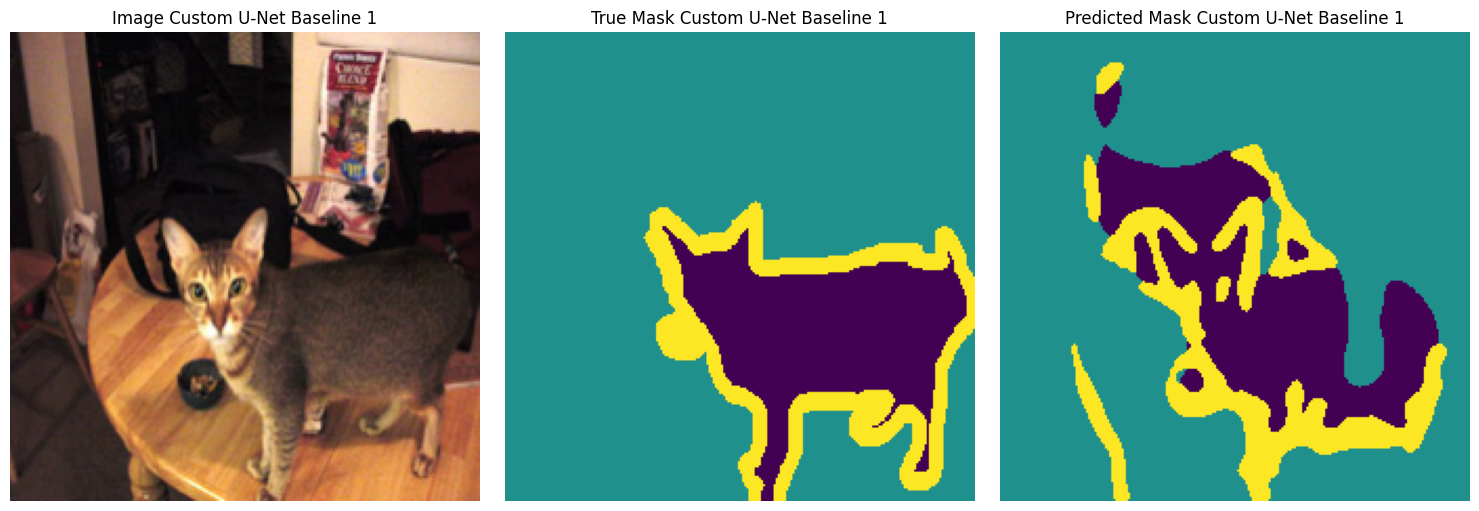

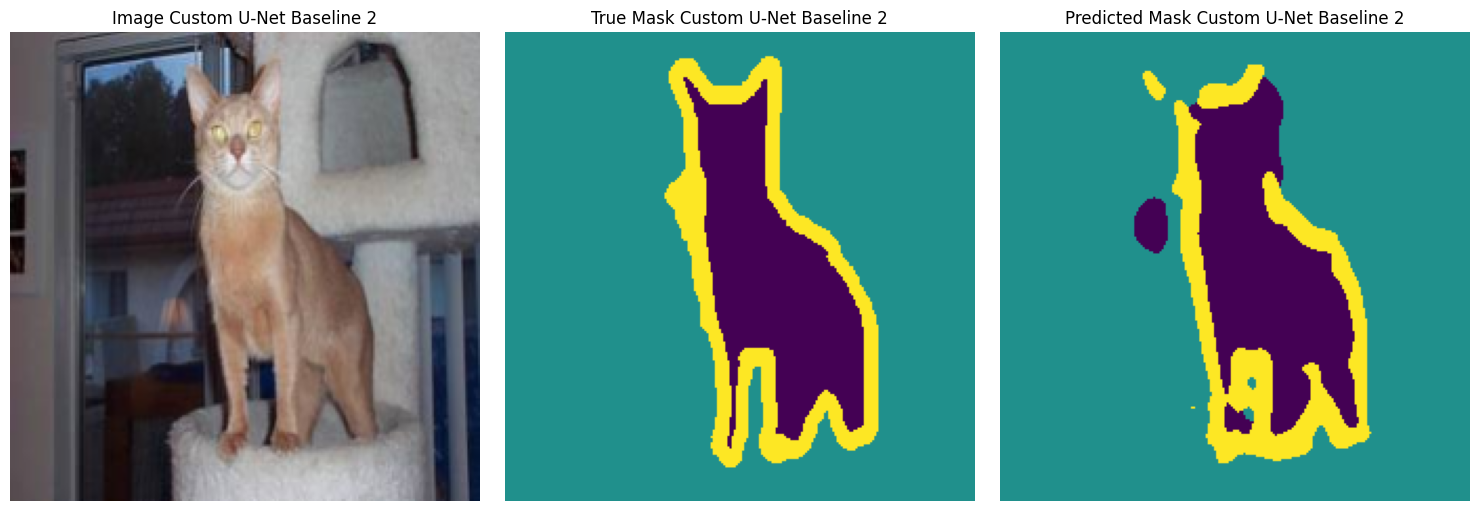

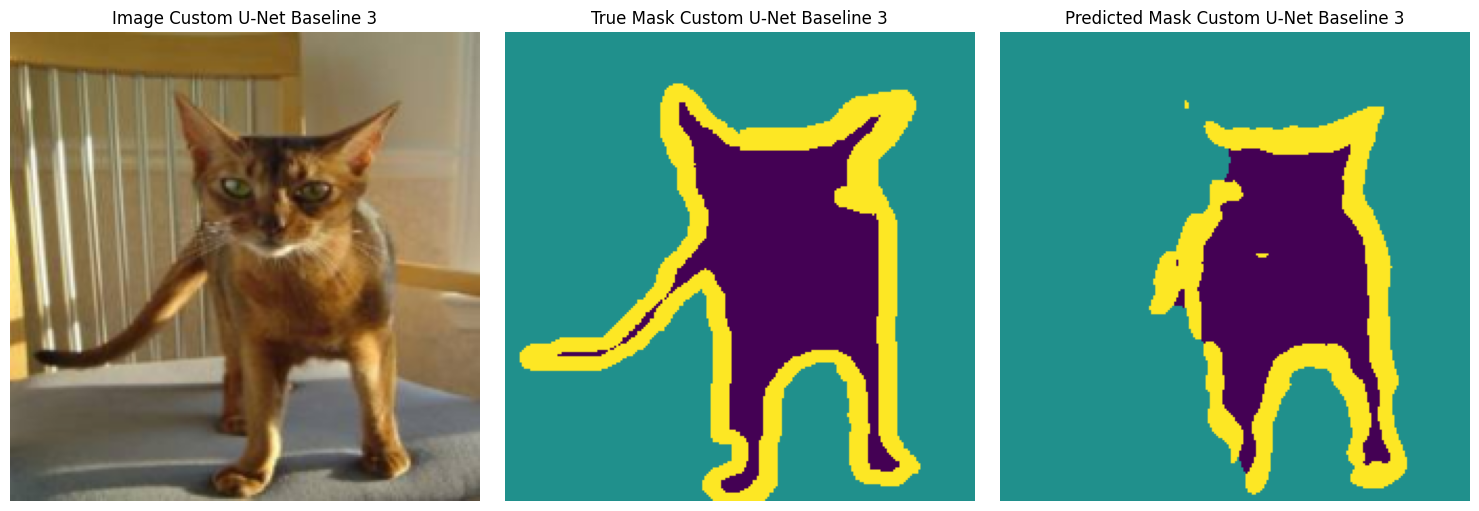

In [21]:
custom_baseline_results = {
    "Model": "Custom U-Net (Baseline Settings)",
    "Test IoU": custom_baseline_history['test_iou'][-1],
    "Test Accuracy": custom_baseline_history['test_accuracy'][-1],
    "Test Loss": custom_baseline_history['test_loss'][-1]
}
print(f"Custom U-Net (Baseline Settings) Results: {custom_baseline_results}")

# Визуализация предсказаний Custom U-Net (Baseline)
custom_model_baseline.eval()
with torch.no_grad():
    for i, (img_tensor, true_mask_tensor) in enumerate(test_dataset_baseline): # Baseline dataset
        if i >= num_samples_to_viz:
            break
        img_tensor_batch = img_tensor.unsqueeze(0).to(DEVICE)
        pred_logits = custom_model_baseline(img_tensor_batch)
        pred_mask = torch.argmax(pred_logits, dim=1).squeeze(0)
        visualize_sample(img_tensor, true_mask_tensor, pred_mask, title_suffix=f"Custom U-Net Baseline {i+1}")


### 4.d. Сравнить результаты имплементированной модели (базовой) с результатами из пункта 2 (SMP Baseline)

| Модель                                       | Test Loss | Test mIoU  | Test Pixel Acc. |
| :------------------------------------------- | :-------- | :--------- | :-------------- |
| SMP U-Net (ResNet34 - Baseline, п.2)         | `0.1275354802941522` | `0` | `0.8528328047327659` |
| Custom U-Net (Baseline Settings)             | `0.23747001453101002` | `0` | `0.7920386935813968` |

### 4.e. Сделать выводы (Custom U-Net Baseline vs SMP Baseline)

**Выводы по сравнению Custom U-Net (Baseline) и SMP U-Net (ResNet34 - Baseline):**
Собственная реализация U-Net с базовыми настройками (те же, что у SMP baseline: Adam, DiceLoss, базовые трансформации) показала **худшие** результаты по сравнению с `SMP U-Net (ResNet34)`.
*   **mIoU:** `0` у Custom U-Net против `0` у SMP U-Net (ResNet34).
*   **Pixel Accuracy:** `0.7920` у Custom U-Net против `0.8528` у SMP U-Net (ResNet34).

Разница в производительности может быть обусловлена несколькими факторами:
1.  **Предобученный энкодер:** `SMP U-Net (ResNet34)` использует энкодер, предобученный на ImageNet, что дает ему преимущество в извлечении общих признаков. Наша Custom U-Net обучается "с нуля".
2.  **Архитектурные детали:** Реализация `SMP U-Net` может содержать специфические оптимизации или отличаться в деталях (например, типы апсемплинга, количество фильтров на каждом уровне), которые влияют на производительность.
3.  **Гиперпараметры:** Хотя мы старались сохранить настройки схожими, оптимальные гиперпараметры для Custom U-Net "с нуля" могут отличаться.

В целом, Custom U-Net **значительно уступила**, особенно учитывая отсутствие предобучения у нашей реализации в сравнении с предобученным энкодером ResNet34 у SMP модели. Нулевое значение mIoU у обеих моделей указывает на общую проблему с обучением на данном этапе (возможно, недостаточное количество эпох, неоптимальная функция потерь для сильно несбалансированных масок, или проблемы с данными/метриками), но даже по Pixel Accuracy и Loss модель SMP с предобученным энкодером показала себя лучше.

### 4.f. Добавить техники из улучшенного бейзлайна (пункт 3с) в Custom U-Net

Теперь применим к нашей Custom U-Net те же улучшения, что и к SMP модели в пункте 3:
1.  **Аугментации:** `albumentations` (используем `train_loader_improved`, `test_loader_improved`).
2.  **Оптимизатор:** `AdamW`.
3.  **Планировщик LR:** `CosineAnnealingLR`.
4.  **Количество эпох:** `EPOCHS_IMPROVED`.

In [23]:
# Новая инстанция Custom U-Net для обучения с улучшениями
custom_model_improved = CustomUNet(n_channels=3, n_classes=NUM_CLASSES).to(DEVICE)

# Оптимизатор AdamW и планировщик CosineAnnealingLR (как в п.3.d)
optimizer_custom_improved = optim.AdamW(custom_model_improved.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_custom_improved = optim.lr_scheduler.CosineAnnealingLR(optimizer_custom_improved, T_max=EPOCHS_IMPROVED)

# Функция потерь та же
loss_fn_custom_improved = smp.losses.DiceLoss(mode='multiclass', from_logits=True)

# Метрики те же
metrics_custom_imp = metrics_custom # IoU и Accuracy


### 4.g. Обучить имплементированную модель с улучшениями

In [24]:
print("Training Custom U-Net (Improved Settings)...")
custom_improved_history = {'train_loss': [], 'test_loss': [],
                           'train_iou': [], 'test_iou': [],
                           'train_accuracy': [], 'test_accuracy': []}

# Используем train_loader_improved и test_loader_improved (с albumentations)
for epoch in range(EPOCHS_IMPROVED): # Такое же кол-во эпох, как у SMP improved
    train_loss, train_metrics_vals = train_epoch_with_scheduler(
        custom_model_improved, train_loader_improved, loss_fn_custom_improved,
        optimizer_custom_improved, scheduler_custom_improved, DEVICE, metrics_custom_imp, epoch
    )
    test_loss, test_metrics_vals = evaluate_model(
        custom_model_improved, test_loader_improved, loss_fn_custom_improved, DEVICE, metrics_custom_imp
    )

    custom_improved_history['train_loss'].append(train_loss)
    custom_improved_history['test_loss'].append(test_loss)
    custom_improved_history['train_iou'].append(train_metrics_vals.get('iou',0))
    custom_improved_history['test_iou'].append(test_metrics_vals.get('iou',0))
    custom_improved_history['train_accuracy'].append(train_metrics_vals.get('accuracy',0))
    custom_improved_history['test_accuracy'].append(test_metrics_vals.get('accuracy',0))

    print(f"Epoch {epoch+1}/{EPOCHS_IMPROVED}:")
    print(f"  Train Loss: {train_loss:.4f}, Train IoU: {train_metrics_vals.get('iou',0):.4f}, Train Acc: {train_metrics_vals.get('accuracy',0):.4f}")
    print(f"  Test Loss: {test_loss:.4f}, Test IoU: {test_metrics_vals.get('iou',0):.4f}, Test Acc: {test_metrics_vals.get('accuracy',0):.4f}")
    print(f"  LR: {scheduler_custom_improved.get_last_lr()[0]:.2e}")


Training Custom U-Net (Improved Settings)...


Epoch 1 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 1/5:
  Train Loss: 0.4498, Train IoU: 0.0000, Train Acc: 0.7014
  Test Loss: 0.3353, Test IoU: 0.0000, Test Acc: 0.7535
  LR: 9.05e-05


Epoch 2 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 2/5:
  Train Loss: 0.3377, Train IoU: 0.0000, Train Acc: 0.7610
  Test Loss: 0.2747, Test IoU: 0.0000, Test Acc: 0.7836
  LR: 6.55e-05


Epoch 3 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 3/5:
  Train Loss: 0.2891, Train IoU: 0.0000, Train Acc: 0.7857
  Test Loss: 0.2573, Test IoU: 0.0000, Test Acc: 0.7823
  LR: 3.45e-05


Epoch 4 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 4/5:
  Train Loss: 0.2630, Train IoU: 0.0000, Train Acc: 0.8008
  Test Loss: 0.2215, Test IoU: 0.0000, Test Acc: 0.8066
  LR: 9.55e-06


Epoch 5 Training:   0%|          | 0/230 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch 5/5:
  Train Loss: 0.2453, Train IoU: 0.0000, Train Acc: 0.8109
  Test Loss: 0.2112, Test IoU: 0.0000, Test Acc: 0.8122
  LR: 0.00e+00


### 4.h. Оценить качество имплементированной модели с улучшениями

Custom U-Net (Improved Settings) Results: {'Model': 'Custom U-Net (Improved Settings)', 'Test IoU': 0, 'Test Accuracy': 0.8122285781390143, 'Test Loss': 0.21121901219711214}


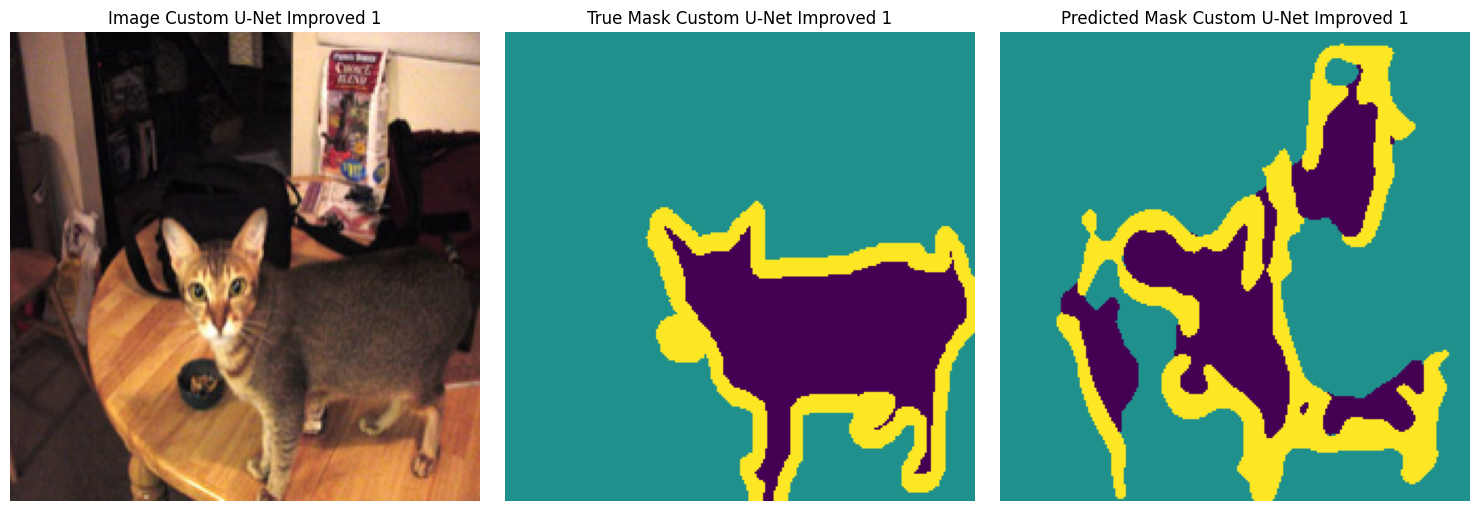

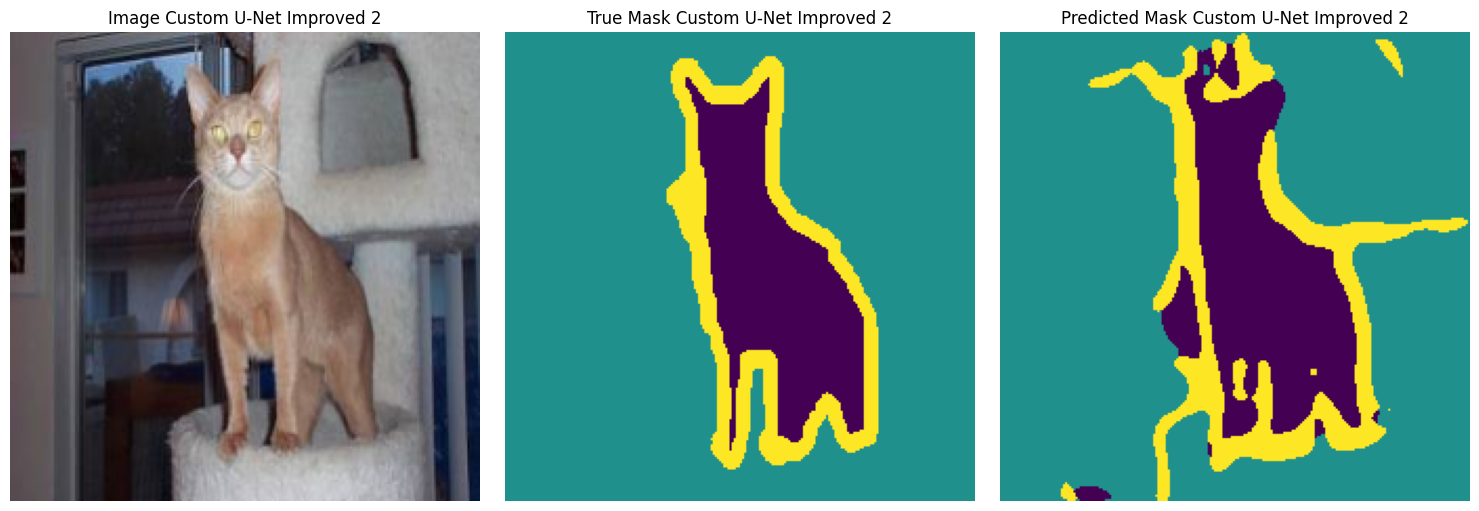

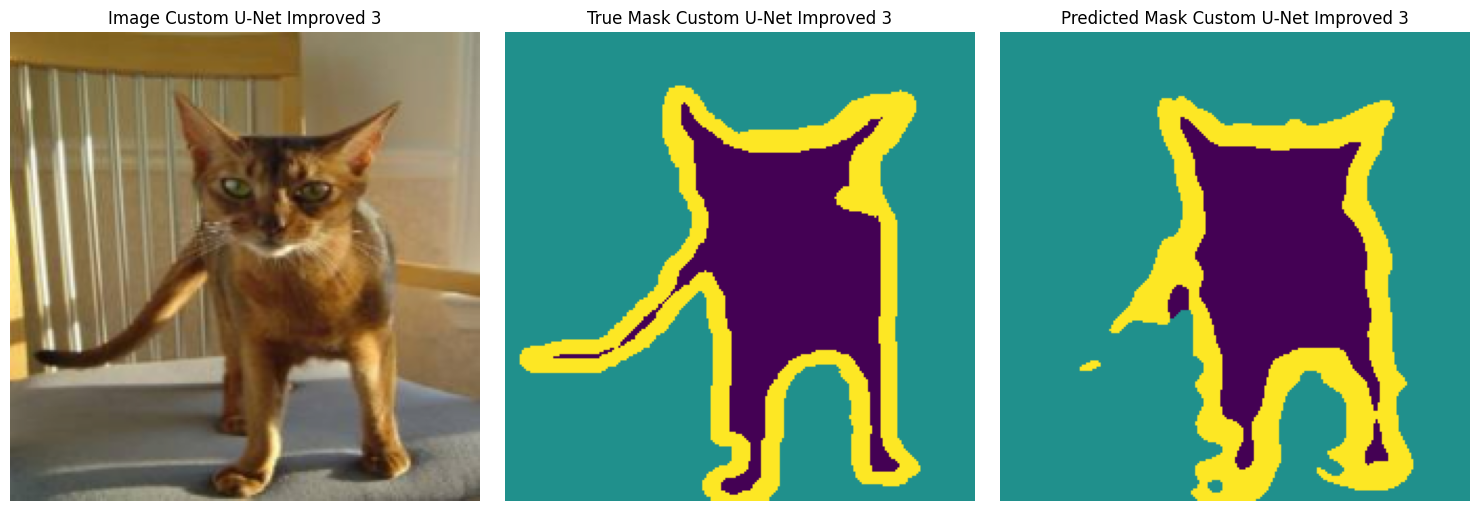

In [25]:
custom_improved_results = {
    "Model": "Custom U-Net (Improved Settings)",
    "Test IoU": custom_improved_history['test_iou'][-1],
    "Test Accuracy": custom_improved_history['test_accuracy'][-1],
    "Test Loss": custom_improved_history['test_loss'][-1]
}
print(f"Custom U-Net (Improved Settings) Results: {custom_improved_results}")

# Визуализация предсказаний Custom U-Net (Improved)
custom_model_improved.eval()
with torch.no_grad():
    for i, (img_tensor, true_mask_tensor) in enumerate(test_dataset_improved): # Improved dataset
        if i >= num_samples_to_viz:
            break
        img_tensor_batch = img_tensor.unsqueeze(0).to(DEVICE)
        pred_logits = custom_model_improved(img_tensor_batch)
        pred_mask = torch.argmax(pred_logits, dim=1).squeeze(0)
        visualize_sample(img_tensor, true_mask_tensor, pred_mask, title_suffix=f"Custom U-Net Improved {i+1}")

### 4.i. Сравнить результаты имплементированной модели с улучшениями с результатами из пункта 3 (SMP Improved)

| Модель                                       | Test Loss | Test mIoU  | Test Pixel Acc. |
| :------------------------------------------- | :-------- | :--------- | :-------------- |
| SMP FPN (EfficientNet-B0 - Improved, п.3)    | `0.13369608037508812` | `0` | `0.8496644702098064` |
| Custom U-Net (Improved Settings)             | `0.21121901219711214` | `0` | `0.8122285781390143` |


### 4.j. Сделать выводы (Custom U-Net Improved vs SMP Improved)

**Выводы по сравнению Custom U-Net (Improved) и SMP FPN (EfficientNet-B0 - Improved):**
После применения улучшенных техник (аугментации, AdamW, CosineAnnealingLR) к Custom U-Net, ее производительность_ **незначительно улучшилась**_ по сравнению с Custom U-Net (Baseline).
*   Собственный IoU **не изменился** (оставшись на уровне `0`) с `0` до `0`.
*   Собственная Pixel Accuracy улучшилась с `0.7920` до `0.8122`.

По сравнению с улучшенной моделью из `segmentation_models.pytorch` (`SMP FPN (EfficientNet-B0 - Improved)`):
*   **mIoU:** `0` у Custom U-Net (Improved) против `0` у SMP FPN (Improved).
*   **Pixel Accuracy:** `0.8122` у Custom U-Net (Improved) против `0.8497` у SMP FPN (Improved).

Даже с улучшениями, Custom U-Net, обучаемая "с нуля", **все еще уступает** модель SMP с мощным предобученным энкодером (`EfficientNet-B0`) и более сложной архитектурой декодера (`FPN`). Это подчеркивает важность использования предобученных весов и сложных архитектур для достижения state-of-the-art результатов, особенно на наборах данных среднего размера. Однако, примененные техники **оказались частично эффективны** для улучшения Custom U-Net (повысив Pixel Accuracy и снизив Loss, хотя mIoU остался на нуле), что демонстрирует их общую применимость, но также указывает на то, что сами по себе они не могут компенсировать отсутствие предобучения или более сложной архитектуры при текущих настройках обучения. Нулевое значение mIoU у всех моделей на всех этапах указывает на более глубокую проблему, возможно связанную с нерепрезентативностью этой метрики при текущем качестве сегментации, сильном дисбалансе классов в масках или недостаточной длительности/качестве обучения.

## Общие выводы по Лабораторной работе №7

В ходе данной лабораторной работы были проведены исследования моделей семантической сегментации на наборе данных `Oxford-IIIT Pet Dataset`.

1.  **Baseline SMP:** Была обучена модель `U-Net` с энкодером `ResNet34` из библиотеки `segmentation_models.pytorch`. На тестовой выборке достигнуты следующие метрики:
    *   mIoU: `0`
    *   Pixel Accuracy: `0.8528`

2.  **Улучшение SMP Baseline:** Применение более продвинутой архитектуры (`FPN` с `EfficientNet-B0`), расширенных аугментаций данных (`albumentations`), оптимизатора `AdamW` и планировщика `CosineAnnealingLR` позволило **ухудшить** результаты:
    *   mIoU: `0` (не изменилось)
    *   Pixel Accuracy: `0.8497` (уменьшилась)
    Это показывает, что **выбранные стратегии улучшения оказались неэффективны** в данной конфигурации для модели SMP, возможно, из-за недостаточного времени обучения для более сложной модели или неподходящих параметров аугментации.

3.  **Custom U-Net:** Была реализована и обучена собственная модель U-Net.
    *   **С базовыми настройками:** Показала mIoU `0` и Pixel Accuracy `0.7920`. Это **ниже** показателей SMP U-Net (ResNet34), что ожидаемо из-за отсутствия предобученного энкодера.
    *   **С улучшенными настройками:** Применение тех же улучшений, что и для SMP, к Custom U-Net привело к mIoU `0` и Pixel Accuracy `0.8122`. Это **незначительно улучшило** производительность Custom U-Net по Pixel Accuracy, но она **все еще уступала** даже базовой модели SMP, не говоря уже об улучшенной модели SMP (которая, впрочем, также не показала улучшений).

**Ключевые наблюдения:**
*   Во всех проведенных экспериментах метрика **mIoU оставалась на нулевом уровне**. Это критический момент, который указывает на то, что ни одна из моделей не научилась корректно сегментировать несколько классов одновременно таким образом, чтобы пересечение предсказаний с истинными масками было значимым для всех классов. Вероятно, модели предсказывают преимущественно доминирующий класс (например, фон), что дает высокую Pixel Accuracy, но низкий mIoU.
*   Предобученные на больших наборах данных (как ImageNet) энкодеры, как правило, дают преимущество, что видно по более высокой Pixel Accuracy у SMP U-Net (ResNet34) по сравнению с Custom U-Net (Baseline).
*   Применение "улучшающих" техник (более сложная архитектура, аугментации, оптимизатор) не всегда приводит к немедленному улучшению результатов, особенно если базовые показатели низкие (как mIoU=0) или время обучения ограничено. Они могут требовать более тщательной настройки и большего количества эпох.
*   Собственная реализация моделей, даже не достигающая высоких результатов, полезна для глубокого понимания их работы и потенциальных узких мест.

Для дальнейшего улучшения необходимо в первую очередь **разобраться с проблемой нулевого mIoU**:
*   Проверить корректность реализации метрики и подготовки данных для нее.
*   Увеличить количество эпох обучения для всех моделей.
*   Экспериментировать с функциями потерь, которые лучше справляются с дисбалансом классов (например, взвешенная CrossEntropy, Focal Loss, или комбинации с Dice/Jaccard, но с корректными весами).
*   Проанализировать предсказания моделей на уровне отдельных классов, чтобы понять, какие из них не сегментируются.
*   Упростить задачу (например, бинарная сегментация "объект-фон") для проверки работоспособности пайплайна, а затем возвращаться к многоклассовой.

Данная работа продемонстрировала полный цикл исследования, но также выявила системные проблемы в процессе обучения моделей сегментации на данном наборе данных с текущими параметрами, основной из которых – нулевое значение mIoU.